## Introduction

You are working as an ML engineer in Visiemo, a famous sound-based sentiment analysis company. It’s Monday morning and you are chilling at the coffee machine with fellow Visiumees. Suddenly, the AI project manager schedules you a project kick-off meeting. A multinational client is interested in our services: the client has different call centers around the world and would like to analyze the satisfaction of its customers based on the recordings of the calls.

The client has heard about AI and Visiemo, more precisely about our expertise in sentiment analysis.
However,the client is reluctant in whether the solution will work. As such, it has been agreed to first do a proof-of-concept on the call centers from Germany.

At Visiemo, we have decided to use an already existing dataset and design a small proof-of-concept to showcase the solution to the client.

## Instructions

In the frame of this use-case, you will be confronted to **Speech Emotion Recognition** with the **Emo-DB** dataset. The goal is to design a proof-of-concept model which classifies samples of emotional speech in one of the given emotions.

By the end of the use-case, you should have a working model with good enough performance, fairly evaluated. 

*We do not aim to have the best performing model.* On the contrary, you should aim for an end-to-end working solution that enables inference on new speech samples.

* As a **report**, you should fill in the present notebook.
* You should dockerize your project. The **Docker container** should handle everything (download the data, run the code, etc.). When running the container **it should expose the Jupyter notebook on one port and expose a Flask API on another one**.
* The **Flask API** should contain two endpoints:
  - One for training the model
  - One for querying the last trained model with an audio file of our choice in the dataset
* The code that you will develop should be **entirely reproducible** and **documented in a README.md file**.

## Final presentation

* The final presentation will be held on-site or remotely depending on your availability. 
* An AI Project Manager and two ML engineers will be present. 
* You will start by giving a 10-15 min technical presentation about your approach and your findings, using the slides provided as deliverables. Finally, a discussion with questions of about 20 min will follow.
* It should be clear enough to understand your approach and your decisions without going too much in the code. 
* You can also include code snippets, demos, etc.

## Important points to keep in mind

* Please be aware that this use-case might take a substantial amount of time, especially if you are not familiar with all the tools.
* You will have one full week to tackle the problem, starting today. We broadly estimate to *15-20 hours* the usual development time needed.
* Don’t spend too much time finding the perfect technical solution or making tiny metric improvements. 
* If you don't manage to finish all the tasks, you can still send us your use-case: we will discuss the difficulties you encountered during the final presentation.
* **Do not upload your code to Github, or at least not in a public repo.**
* Feel free to use any available library you would need, but **do not re-use someone else's code without mentioning it.**

## Deliverables 

Please provide the following elements in a **.zip** file as deliverables:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work.
* A **Dockerfile** defining a container for the project expositing the present notebook and the Flask API.
* A **README.md** which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* **Any** necessary .py, .sh or other files needed to run your code.

You will be judged on your technical approach, evaluation, visualizations, coding and presentation skills.

## About the data

The dataset can be found [here](http://emodb.bilderbar.info/index-1280.html).

It contains samples of emotional speech in German, labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information").

# Libraries Loading

In [1]:
import numpy as np
import pandas as pd
import torchvision.transforms as T
import os
import sklearn
import librosa
import librosa.display
import json
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, random_split, DataLoader
from skimage import io
from torchvision.utils import make_grid
from utils import pytorchtools
from utils import preprocessing
import torch
import seaborn as sns
from tqdm import tqdm
from moviepy.video.io.bindings import mplfig_to_npimage
from torchmetrics import PrecisionRecallCurve
from utils.preprocessing import plot_mel


# Data Preparation & Cleaning

In [2]:
# A	anger	                    W	Ärger (Wut)
# B	boredom	                    L	Langeweile
# D	disgust	                    E	Ekel
# F	anxiety/fear	            A	Angst
# H	happiness	                F	Freude
# S	sadness	                    T	Trauer
    
def decompose_emodb(EMODB_PATH):
    'Name Folder same as file extension'
    # EMODB_PATH = './dataset/wav/'
    emotion = []
    path = []
    for root, dirs, files in os.walk(EMODB_PATH):
        for name in files:
            if name[5] == 'W':  # Ärger (Wut) -> Angry
                emotion.append('angry')
            elif name[5] == 'L':  # Langeweile -> Boredom
                emotion.append('bored')
            elif name[5] == 'E':  # Ekel -> Disgusted
                emotion.append('disgust')
            elif name[5] == 'A':  # Angst -> Angry
                emotion.append('fear')
            elif name[5] == 'F':  # Freude -> Happiness
                emotion.append('happy')
            elif name[5] == 'T':  # Trauer -> Sadness
                emotion.append('sad')
            elif name[5] == 'N':
                emotion.append('neutral')
            else:
                emotion.append('unknown')
            path.append(os.path.join(EMODB_PATH, name))

    emodb_df = pd.DataFrame(emotion, columns=['labels'])
    emodb_df = pd.concat([emodb_df, pd.DataFrame(path, columns=['path'])], axis=1)
    
    return emodb_df

### Exploratory Data Analysis

<AxesSubplot:xlabel='labels', ylabel='count'>

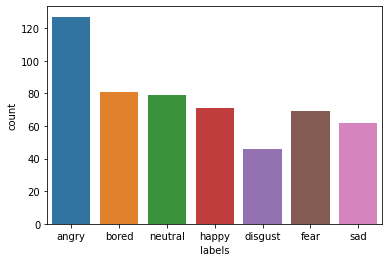

In [3]:
audio_dataset_path = './dataset/wav/'
dataset_summary = decompose_emodb(audio_dataset_path)
sns.countplot(x ='labels',data=dataset_summary)

In [4]:
class_dist = dataset_summary.groupby('labels').count().reset_index()[['labels','path']]
class_dist.columns = ['labels','count']
class_dist

,labels,count
0,angry,127
1,bored,81
2,disgust,46
3,fear,69
4,happy,71
5,neutral,79
6,sad,62


#### Split to train and test

# Feature Engineering & Modeling

In [5]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('./dataset/wav/09b03Ed.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

In [6]:
image_dataset_path = './dataset/jpeg/'
dataset_exists = os.path.exists(image_dataset_path)
if not dataset_exists:
  # Create a new directory because it does not exist 
  os.makedirs(image_dataset_path)
  print("directory is created!")

In [7]:
images_count = len(os.listdir(image_dataset_path))
audio_count =  len(os.listdir(audio_dataset_path))

In [ ]:
print('TrainingStart')

In [8]:
if images_count != audio_count:
    for path in tqdm(dataset_summary['path']):
        jpeg_path = path.replace('wav','jpeg')
        audio, rate = librosa.load(path)
        fig = plot_mel(audio,rate)
        fig.savefig(jpeg_path)
#         # convert it to a numpy array
#         numpy_image = mplfig_to_npimage(fig)
#         torch.tensor(numpy_image)

100%|██████████| 535/535 [03:57<00:00,  2.25it/s]


In [9]:
dataset_summary = decompose_emodb(image_dataset_path)

In [10]:
labels = dataset_summary.labels.unique()
le = sklearn.preprocessing.LabelEncoder()
targets = le.fit_transform(labels)
le.inverse_transform(targets)

array(['sad', 'angry', 'happy', 'fear', 'neutral', 'disgust', 'bored'],
      dtype=object)

In [11]:
preprocessing.label_encoder_to_json(le,'labels.json')

In [12]:
dataset_summary.replace(labels,le.fit_transform(labels),inplace=True)

In [13]:
dataset_summary

,labels,path
0,6,./dataset/jpeg/16a05Tb.jpeg
1,6,./dataset/jpeg/09a07Ta.jpeg
2,0,./dataset/jpeg/09a04Wa.jpeg
3,0,./dataset/jpeg/14b02Wb.jpeg
4,4,./dataset/jpeg/16b10Fb.jpeg
...,...,...
530,1,./dataset/jpeg/16b10Lb.jpeg
531,0,./dataset/jpeg/08a01Wc.jpeg
532,6,./dataset/jpeg/12a05Ta.jpeg
533,0,./dataset/jpeg/08b10Wa.jpeg


In [14]:
targets

array([6, 0, 4, 3, 5, 2, 1])

In [15]:
class EmoDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        
        image_label = self.df.iloc[idx]['labels']
        image_path = self.df.iloc[idx]['path']
        
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        return (image, image_label)

In [16]:
dataset_summary

,labels,path
0,6,./dataset/jpeg/16a05Tb.jpeg
1,6,./dataset/jpeg/09a07Ta.jpeg
2,0,./dataset/jpeg/09a04Wa.jpeg
3,0,./dataset/jpeg/14b02Wb.jpeg
4,4,./dataset/jpeg/16b10Fb.jpeg
...,...,...
530,1,./dataset/jpeg/16b10Lb.jpeg
531,0,./dataset/jpeg/08a01Wc.jpeg
532,6,./dataset/jpeg/12a05Ta.jpeg
533,0,./dataset/jpeg/08b10Wa.jpeg


In [17]:
from sklearn.model_selection import train_test_split

# 0.8 * 0.125 gives 0.1 for validation
train_df,test_df = train_test_split(dataset_summary, test_size=0.2,stratify=dataset_summary.labels)
train_df,valid_df = train_test_split(train_df,test_size=0.125,stratify=train_df.labels)

<AxesSubplot:xlabel='labels', ylabel='count'>

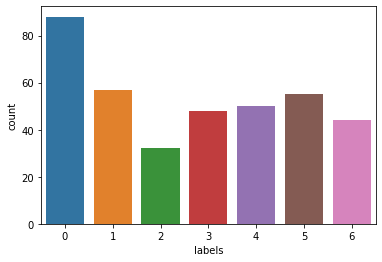

In [18]:
sns.countplot(x ='labels',data=train_df)

<AxesSubplot:xlabel='labels', ylabel='count'>

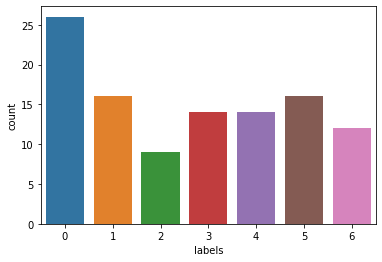

In [19]:
sns.countplot(x ='labels',data=test_df)

<AxesSubplot:xlabel='labels', ylabel='count'>

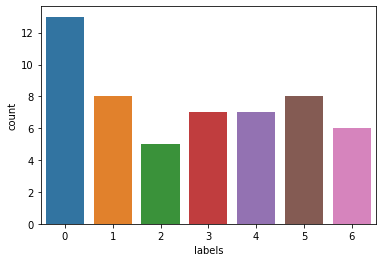

In [20]:
sns.countplot(x ='labels',data=valid_df)

In [21]:
train_df.reset_index(inplace=True,drop=True)
test_df.reset_index(inplace=True,drop=True)
valid_df.reset_index(inplace=True,drop=True)

In [22]:
resize = T.Compose([T.Resize((256,256)),
                             T.ToTensor()])

In [23]:
train_dataset = EmoDataset(train_df, transform=resize)
test_dataset = EmoDataset(test_df, transform=resize)
valid_dataset = EmoDataset(valid_df, transform=resize)

In [24]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32,shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=32,shuffle=True)

In [25]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0))
        break

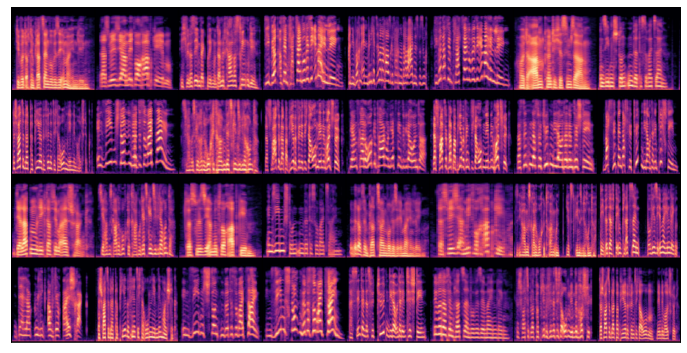

In [26]:
show_batch(valid_loader)

In [27]:
# sample execution (requires torchvision)
from PIL import Image
import torch as torch
from torchvision import transforms

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
## USE APPLE M1 GPU
try:
    if torch.backends.mps.is_available():
        device = torch.device('mps')
except AttributeError:
    print(device)
        

cpu


In [29]:
for d,l in valid_loader:
    print(len(l))

32
22


In [30]:
import torch
# model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)


##REPLACE LAST LAYER
num_labels = len(dataset_summary['labels'].unique())
model.classifier[6] = torch.nn.Linear(4096,num_labels)
#Freeze the gradients of all of the layers in the features (convolutional) layers
# for param in model.features.parameters():
#     param.requires_grad = False



params = {'learning_rate':1e-5,'epochs':500, 'patience':20}
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
running_loss = 0
losses = []

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [31]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [32]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

In [33]:
def testAccuracy(model, test_loader, device):
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for images,labels in test_loader:
            # run the model on the test set to predict labels
            images=images.to(device)
            labels = labels.to(device)
            outputs = model(images).to(device)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (accuracy / total)
    return accuracy

In [34]:
size = len(train_loader.dataset)
print(size)

# initialize the early_stopping object
early_stopping = pytorchtools.EarlyStopping(patience=params['patience'],verbose=True)

for epoch in range(params['epochs']):
    #######TRAIN MODEL########
    epochs_loss=0

    model.train()
    for i, (images,labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)

        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        #calculate train_loss
        train_losses.append(loss.item())
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
        optimizer.step()
    ##########################    
    #####TEST MODEL#######
    ##########################    
    accuracy = testAccuracy(model, test_loader, device)
    ##########################    
    #####VALIDATE MODEL#######
    ##########################
    model.eval()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        loss = criterion(outputs,labels)
        valid_losses.append(loss.item())
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    #print(train_loss)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    print_msg = (f'accuracy: {accuracy:.3f} ' + f'train_loss: {train_loss:.3f} ' + f'valid_loss: {valid_loss:.3f}')
    
    print(print_msg)

    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    early_stopping(valid_loss, model)
    print(epoch)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

374
accuracy: 0.243 train_loss: 1.946 valid_loss: 1.942
Validation loss decreased (inf --> 1.942445).  Saving model ...
0


In [35]:
def error_analysis(test_loader, model, label_encoder, device):
    model.eval()
    preds = []
    true_labels = []
    for images, labels in test_loader:

        data, target = images.to(device), labels.to(device)
        output = model(data)  # shape = torch.Size([batch_size, 10])
        pred = output.argmax(
            dim=1, keepdim=True
        )  # pred will be a 2d tensor of shape [batch_size,1]

        preds.append(pred.flatten().to("cpu").numpy())
        true_labels.append(labels.flatten().to("cpu").numpy())

    #### GET MISIDENTIFIED EXAMPLE
    all_preds = np.concatenate(preds, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    df = pd.DataFrame({"expected": true_labels, "predicted": all_preds})

    ### DECODE LABELS in datafram
    for col in df:
        df[col] = label_encoder.inverse_transform(df[col])

    return df

In [36]:
from collections import defaultdict

errs = error_analysis(test_loader,model, le, device)

In [37]:
errs

,expected,predicted
0,sad,angry
1,bored,angry
2,angry,angry
3,fear,angry
4,bored,angry
...,...,...
102,neutral,angry
103,angry,angry
104,disgust,angry
105,angry,angry


# Results & Visualizations

0


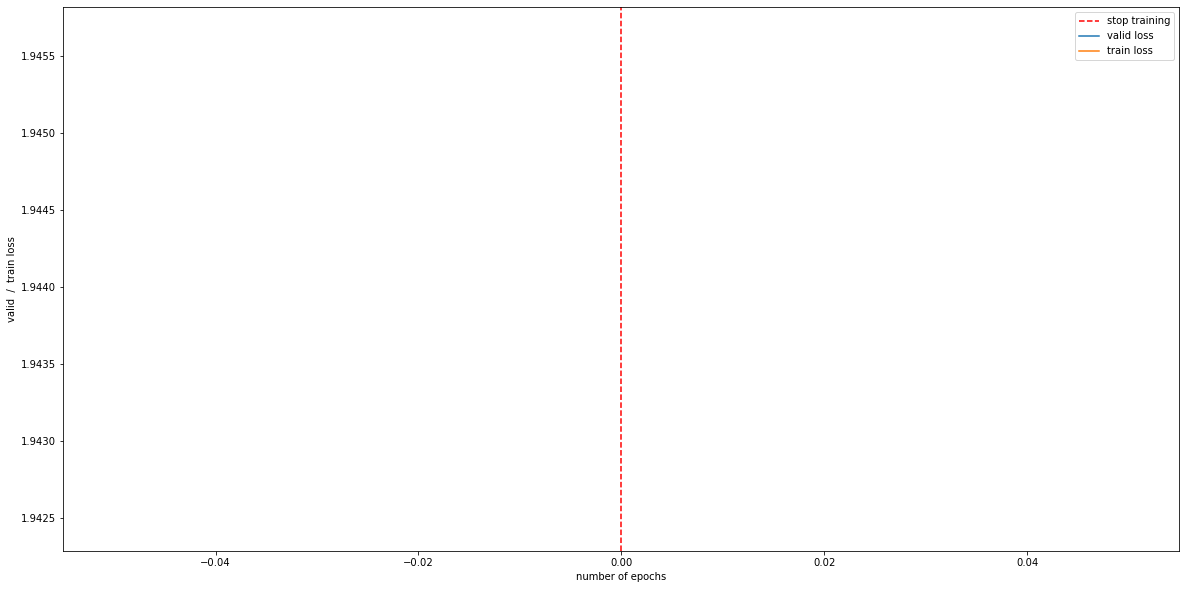

In [38]:
fig = plt.figure(figsize=(20,10))
######1st plot#########
ax1 = fig.add_subplot()
ax1.set_ylabel('valid  /  train loss')
ax1.set_xlabel('number of epochs')
halt = avg_valid_losses.index(min(avg_valid_losses))


plt.axvline(x=halt, color='r', linestyle="--", label="stop training")

print(avg_valid_losses.index(min(avg_valid_losses)))


plt.plot(list(range(len(avg_valid_losses))), avg_valid_losses, label = "valid loss")
plt.plot(list(range(len(avg_valid_losses))), avg_train_losses, label="train loss")


h,labels = ax1.get_legend_handles_labels()
labels[:1] = ['stop training','valid loss', 'train loss',]
ax1.legend(labels=labels)


In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

def generate_confusion_matrix(y_true,y,classes):
    cf_matrix = confusion_matrix(y_true, y)
    plt.figure(figsize=(15, 10))
    ax= plt.subplot()
    sns.heatmap(cf_matrix, annot=True)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    plt.savefig('./matrix.jpeg')

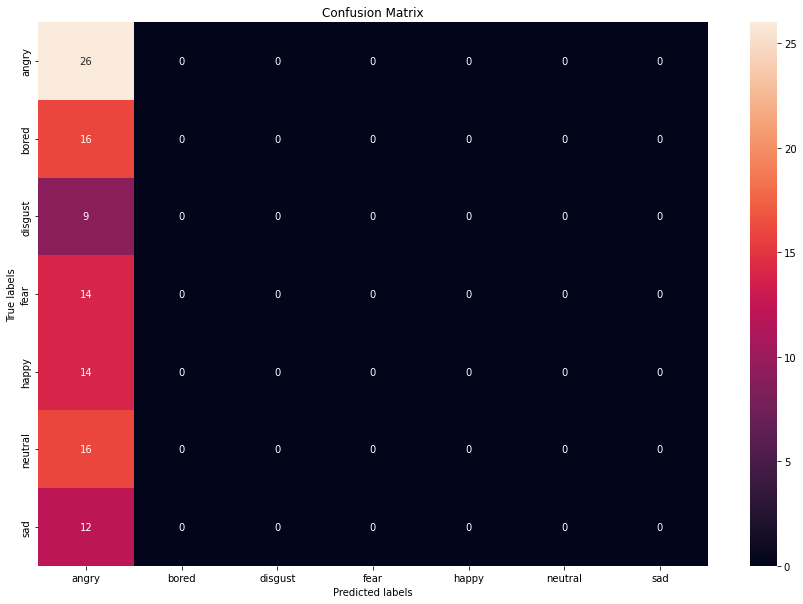

In [41]:
generate_confusion_matrix(errs['expected'], errs['predicted'],le.classes_)